# Data preparation for CWGAN

## PV

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use(['science','no-latex'])
# print(plt.rcParams.keys())
plt.rcParams.update({
    'axes.labelsize': 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.titlesize": 22,
    'legend.fontsize': 'large'
})

pth = "data/PV_jz.csv"
pv = pd.read_csv(pth)
pv["ds"] = pd.to_datetime(pv["ds"])
pv["value"] = pv["value"] / pv["value"].max()

fig, ax = plt.subplots(2, figsize=[20, 10])
ax[0].plot(pv["ds"], pv["value"])
ax[1].plot(pv["ds"][:96 * 7], pv["value"][:96 * 7], lw=3)
ax[0].set(ylabel='Power Output', title='Solar Outputs (p.u.)')
ax[1].set(xlabel='Time', ylabel='Power Output')
fig.savefig("data/PV_jz.png", dpi=300, transparent=True, bbox_inches="tight")
# ax[2].hist(pv["value"], bins=80, histtype="stepfilled", alpha=.8)

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import pickle
from sklearn.preprocessing import StandardScaler
from utils import scale, encode


def split_timestamp(pth) -> pd.DataFrame:
    df = pd.read_csv(pth)

    df_time = df["ds"].str.split(' ', expand=True)
    df_date = df_time[0].str.split('/', expand=True)
    df_date.columns = ["year", "month", "date"]
    df_hour = df_time[1].str.split(':', expand=True)
    df_hour.columns = ["hour", "minute"]

    df_all_time = pd.concat([df_date, df_hour, df[["value"]]], axis=1)
    df_all_time = df_all_time.astype("float")

    return df_all_time


pth = "data/PV_jz.csv"
df = split_timestamp(pth)

# drop useless feature
df.drop(["year", "value", "minute", "hour", "date"], axis=1, inplace=True)
pv_reshape = pd.read_csv(pth).values[:, -1].reshape(-1, 96)
scaler = float(pv_reshape.max())
pv_reshape = pv_reshape / scaler
df = encode(df, "month", 12)
df.drop(["month"], axis=1, inplace=True)
print(f"max value: {scaler}")
df = df.values

# concat each day data
results = np.zeros([pv_reshape.shape[0], pv_reshape.shape[1] + df.shape[1]])
start = 0
for i in range(len(pv_reshape)):

    results[i, :] = np.concatenate([pv_reshape[i, :], df[start, :]], axis=0)
    start = start + 96
print(results)
# split, scale and save
pv_train, pv_test = train_test_split(results, test_size=0.2, shuffle=False)
scale(pv_train, 0, pv_test, scaler=scaler, name="pv")

## Wind

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import scienceplots
plt.style.use(['science','no-latex'])
plt.rcParams.update({
    'axes.labelsize': 20,
    "xtick.labelsize": 18,
    "ytick.labelsize": 18,
    "axes.titlesize": 22,
})

time_col = pd.DataFrame(pd.date_range(start="1/1/2019 00:00:00",
                                      end="12/31/2021 23:45:00",
                                      freq="15min"),
                        columns=["ds"])
wind = pd.read_csv("data/wind_sps.csv")
wind["ds"] = pd.to_datetime(wind["ds"])
print("expected length:\t", len(time_col))
print("wind length:\t", len(wind))
wind = pd.merge(time_col, wind, how="outer")
wind = wind.ffill()
wind["value"] = wind["value"]+1
wind["value"] = wind["value"]/ wind["value"].max()
# wind.to_csv("data/wind_sps.csv", index=False)
fig, ax = plt.subplots(2, figsize=[20, 10])
ax[0].plot(wind["ds"], wind["value"])
ax[1].plot(wind["ds"][:96*7], wind["value"][:96*7], lw=3)
ax[0].set(ylabel='Power Output', title='Wind Outputs (p.u.)')
ax[1].set(xlabel='Time', ylabel='Power Output')
fig.savefig("data/wind_sps.png", dpi=300, transparent=True, bbox_inches="tight")

# ax[2].hist(wind["value"], bins=80, histtype="stepfilled", alpha=.8)


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
import pickle
from utils import scale


def split_timestamp(pth) -> pd.DataFrame:
    df = pd.read_csv(pth)
    df_time = df["ds"].str.split(' ', expand=True)
    df_date = df_time[0].str.split('-', expand=True)
    df_date.columns = ["year", "month", "date"]
    df_hour = df_time[1].str.split(':', expand=True)
    df_hour.columns = ["hour", "minute", "second"]
    df_all_time = pd.concat([df_date, df_hour, df[["value"]]], axis=1)
    df_all_time = df_all_time.astype("float")
    return df_all_time


pth = "data/wind_sps.csv"
df = split_timestamp(pth)

# drop useless feature
df.drop(["year", "value", "minute", "hour", "second"], axis=1, inplace=True)
wind_reshape = pd.read_csv(pth).values[:, -1].reshape(-1, 96)
scaler = float(wind_reshape.max())
wind_reshape = wind_reshape / scaler

###############################################
############ Bins and One-Hot #################
###############################################

avg = wind_reshape.mean(axis=1)
# wind_reshape = np.concatenate(
#     [wind_reshape, wind_reshape.mean(axis=1).reshape(-1, 1)], axis=1)
temp = np.zeros_like(avg)
cond_1 = avg < 0.2
cond_2 = (avg >= 0.2) * (avg < 0.4)
cond_3 = (avg >= 0.4) * (avg < 0.6)
cond_4 = (avg >= 0.6) * (avg < 0.8)
cond_5 = avg >= 0.8
conds = [cond_1, cond_2, cond_3, cond_4, cond_5]
t = None
for i in range(len(conds)):
    if t is None:
        t = np.where(conds[i], temp + i, temp)
    else:
        t += np.where(conds[i], temp + i, temp)
t = t.astype(int)
print(len(t[t==0]))
print(wind_reshape.shape)
wind_reshape = np.concatenate([wind_reshape, np.eye(len(conds))[t]], axis=1)
results = wind_reshape
# print(results[:, :96])
# print(results[:, 96:])

#####################################################
############## Concat Calendar data #################
#####################################################
# print(f"max value: {scaler}")
# df = df.values
# results = np.zeros(
#     [wind_reshape.shape[0], wind_reshape.shape[1] + df.shape[1]])
# start = 0
# for i in range(len(wind_reshape)):
#     results[i, :] = np.concatenate([wind_reshape[i, :], df[start, :]], axis=0)
#     start = start + 96
# print(f"max value: {results}")

#####################################################
############## Saving data ##########################
#####################################################
# train, test = train_test_split(results, test_size=0.2, shuffle=False)
# print(train.shape)
# print(test.shape)
# scale(train, 0, test, scaler=scaler, name="wind")


# Test Trained GAN

[Text(0.5, 1.0, 'wind')]

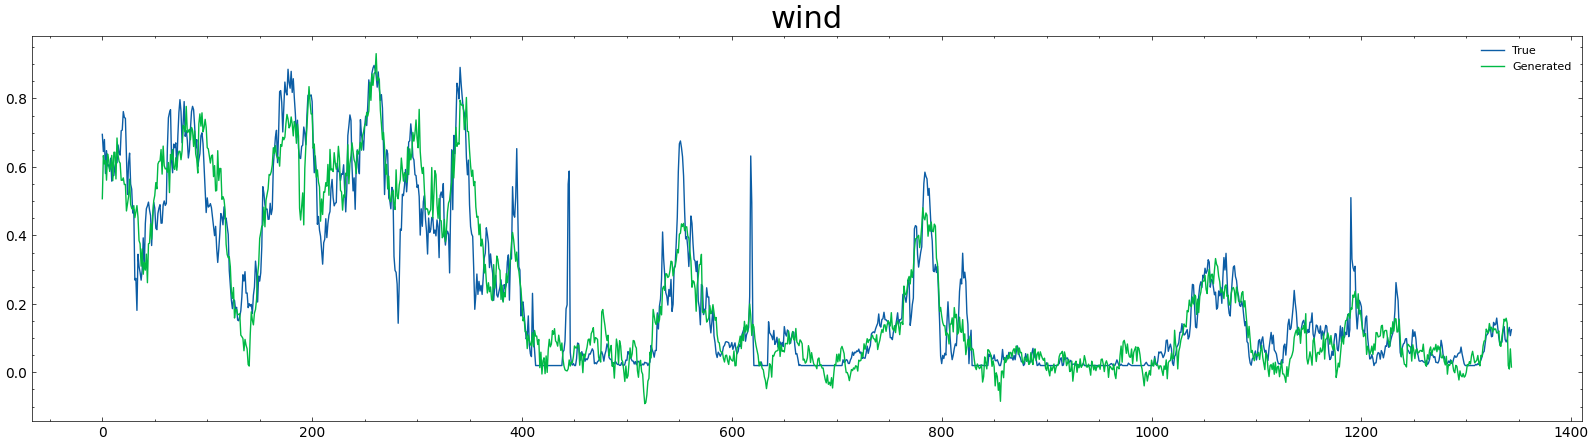

In [23]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import scienceplots
plt.style.use(['science', 'no-latex', "nature"])
plt.rcParams.update({
    'axes.labelsize': 15,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize": 22,
    "legend.fontsize": 8
})

power_type = "wind"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
# scaler = mydata["scaler"]
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()

final_results = []
# choose = 5
# for i in range(choose):
for i in range(len(test_ds)):
    select = i

    # select = 50
    target = test_ds[select, :96]
    cond = test_ds[select, 96:].reshape(1, -1)

    cond = torch.from_numpy(cond).float().cuda()

    num = 2500
    dist = 1e10
    idx = 0
    record = []
    for i in range(num):
        z = torch.normal(0, 1, [1, 96]).cuda()
        # break
        y_hat = generator(z, cond)
        y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
        y_hat = y_hat.astype(float)
        if np.linalg.norm(y_hat - target) < dist:
            dist = np.linalg.norm(y_hat - target)
            idx = i
        record.append(y_hat)
    best_fit = record[idx]
    final_results.append(best_fit)
final_results = np.concatenate(final_results, axis=0)

start = 100
plot_len = 96 * 14
end = start + plot_len
fig, ax = plt.subplots(figsize=[20, 5])
ax.plot(range(plot_len), test_ds[:, :96].flatten()[start:end], label="True")
ax.plot(range(plot_len), final_results[start:end], label="Generated")
ax.legend()
ax.set(title=f"{power_type}")


In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
from utils import autocor
import scienceplots

plt.style.use(['science', 'no-latex', "nature"])
plt.rcParams.update({
    'axes.labelsize': 15,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
    "axes.titlesize": 22,
    "legend.fontsize": 8
})

power_type = "wind"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
# scaler = mydata["scaler"]
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()

final_results = []
final_tests = []
choose = 5

for i in range(choose):
    select = np.random.randint(len(test_ds) - 1)
    target = test_ds[select, :96]
    cond = test_ds[select, 96:].reshape(1, -1)
    cond = torch.from_numpy(cond).float().cuda()

    num = 2500
    dist = 1e10
    idx = 0
    record = []
    for i in range(num):
        z = torch.normal(0, 1, [1, 96]).cuda()
        # break
        y_hat = generator(z, cond)
        y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
        y_hat = y_hat.astype(float)
        if np.linalg.norm(y_hat - target) < dist:
            dist = np.linalg.norm(y_hat - target)
            idx = i
        record.append(y_hat)
    best_fit = record[idx]
    final_results.append(best_fit)
    final_tests.append(target)

fig, axs = plt.subplots(3, choose, figsize=[15, 5])
for j in range(choose):
    atc_tgt = autocor(final_tests[j], lags=48, plot=False)
    atc_best = autocor(final_results[j], lags=48, plot=False)

    axs[0, j].plot(range(len(final_tests[j])),
                   final_tests[j],
                   label="True",
                   lw=2)
    if j == 0:
        axs[0, j].set(ylabel="True")
        axs[1, j].set(ylabel="Generated")
    axs[1, j].plot(range(len(final_results[j])),
                   final_results[j],
                   label="Generated",
                   lw=2,
                   color="C1")
    axs[2, j].plot(range(len(atc_tgt)),
                   atc_tgt,
                   label="True",
                   lw=2)
    axs[2, j].plot(range(len(atc_tgt)),
                   atc_best,
                   label="Generated",
                   lw=2)
    axs[0, j].set(xlim=(0, 96), ylim=(0, 1))
    axs[1, j].set(xlim=(0, 96), ylim=(0, 1))
    # if j == (choose -1):
    #     axs[j].legend(loc=1)
# fig.savefig(f"data/{power_type}_gen.png", dpi=300, transparent=True)

# start = 100
# plot_len = 96 * 14
# end = start + plot_len
# ax.plot(range(plot_len), test_ds[:, :96].flatten()[start:end], label="True")
# ax.plot(range(plot_len), final_results[start:end], label="Generated")
# ax.legend()
# ax.set(title=f"{power_type}")


In [ ]:
import torch
import pickle
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
from sklearn.preprocessing import StandardScaler

power_type = "pv"
condition = True
mydata = pickle.load(open(f'loggings/{power_type}_preprocess.pkl', 'rb'))
# scaler = mydata["scaler"]
test_ds = mydata["test_ds"]
test_ds = test_ds.astype(float)

generator = torch.load(f"loggings/{power_type}_C{condition}_G.pth")
generator.eval()

final_results = []
z = torch.normal(0, 1, [1, 96]).cuda()

# ##################################
# ############# Wind ###############
# ##################################

# for i in range(5):
#     select = np.random.randint(len(test_ds) - 1)
#     cond = np.eye(5)[i].reshape(1, -1)
#     print(cond)
#     cond = torch.from_numpy(cond).float().cuda()
#     y_hat = generator(z, cond)
#     y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
#     y_hat = y_hat.astype(float)
#     final_results.append(y_hat)

#################################
############# PV ################
#################################
for i in range(12):
    select = np.random.randint(len(test_ds) - 1)
    cond = [np.sin(2 * np.pi * (i + 1) / 12), np.cos(2 * np.pi * (i + 1) / 12)]
    cond = np.array(cond).reshape(1, -1)
    print(cond)
    cond = torch.from_numpy(cond).float().cuda()
    # break
    y_hat = generator(z, cond)
    y_hat = y_hat.detach().cpu().numpy().reshape(target.shape)
    y_hat = y_hat.astype(float)
    final_results.append(y_hat)


NCURVES = len(final_results)
np.random.seed(101)

values = range(NCURVES)
fig, ax = plt.subplots(figsize=[5, 5])

jet = cm = plt.get_cmap('jet') 
cNorm  = colors.Normalize(vmin=0, vmax=values[-1])
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)

for i in range(NCURVES):
    colorVal = scalarMap.to_rgba(values[i])
    colorText = (
        'color: (%4.2f,%4.2f,%4.2f)'%(colorVal[0],colorVal[1],colorVal[2])
        )
    retLine  = ax.plot(range(96), final_results[i], label=f"Con_{i+1}", color=(colorVal[0],colorVal[1],colorVal[2]))
    ax.legend()
    ax.set(xlabel="Time", ylabel="Power Outputs", ylim=(0, 1))
fig.savefig(f"data/noise_{power_type}_2.png", transparent=True, dpi=300)


# Evaluation

correlation dist: 0.0480054272733238
W dist: 0.009956631860079604


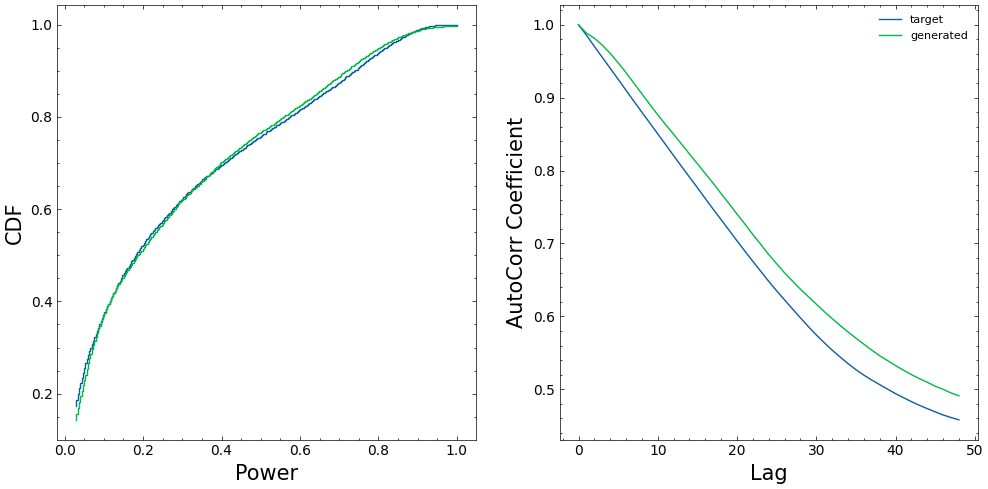

In [24]:
from utils import autocor, cdf, psd, ws_dist, cor_dist, dtw_dist
import numpy as np

target = test_ds[:, :96].flatten()
best_fit = final_results

fig, ax = plt.subplots(1, 2, figsize=[10, 5])
fn_target = cdf(target)
fn_fit = cdf(best_fit)
x = np.linspace(0.03, 1, 300)
ax[0].step(x, fn_target(x), label="target")
ax[0].step(x, fn_fit(x), label="generated")
ax[0].set(ylabel="CDF", xlabel="Power")

atc_tgt = autocor(target, lags=48, plot=False)
atc_best = autocor(best_fit, lags=48, plot=False)
ax[1].plot(range(len(atc_tgt)), atc_tgt, label="target")
ax[1].plot(range(len(atc_tgt)), atc_best, label="generated")
ax[1].set(ylabel="AutoCorr Coefficient", xlabel="Lag")

# atc_tgt, freq_tgt = psd(target)
# atc_best, freq_best = psd(best_fit)
# ax[1][0].plot(freq_tgt, atc_tgt, label="target")
# ax[1][0].plot(freq_best, atc_best, label="generated")

ax[1].legend()
fig.tight_layout()
plt.subplots_adjust(wspace=0.2, hspace=0.1)
print("correlation dist:", cor_dist(target, best_fit))
print("W dist:", ws_dist(target, best_fit))
# fig.savefig("data/pv_eval.png", transparent=True, dpi=300)
